# Lasso Regression

Lasso regression is also used as a penalty to the weights, therefore, reducing the complexity of the model, preventing overfitting, and guarding against multi-collinearity.  

This is the $L1$ penalty. 

\begin{align}
    min_x(||y - Xw||^2_2 + \lambda ||w||^1_1)
\end{align}  

This is visualized as the sum of the absolute value of components of the vector $w$. The longer this vector is, the more it is penalized. 

The hands-on coding of this is identical to the Ridge regression coding from lesson 12. 

We will do both a manual, under-the-hood lasso regression and a comodified, over-the-hood lasso regression with pre-built scikit-learn package.

# Imports

In [1]:
# Adjust parent directory
%cd ..

/Users/jaimemerizalde/Desktop/Library/Machine Learning Udemy Course


In [14]:
from Library import data
import pandas as pd
import numpy as np

import csv

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from yellowbrick.regressor import AlphaSelection

# Get Data

In [3]:
df = data.get_data("Datasets/LifeExpectancy.csv", index_col=[0])
df

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


# Preprocessing

In [4]:
# get object columns
categorical_columns = list(df.dtypes[df.dtypes=="O"].index.values)
categorical_columns

# recast objects as categorical columns
for column in categorical_columns:
    df[column] = df[column].astype("category")
df.dtypes

# Segragate features and responses:
X = df.loc[:, df.columns != "life_expectancy"]
y = df["life_expectancy"]



# Train-test-split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Remove missing and categorical/nonnumerical values
X_train, y_train = data.remove_missing_and_nonNumerical_values(X_train, y_train)
X_test, y_test = data.remove_missing_and_nonNumerical_values(X_test, y_test)


Original Size X: (1968, 21) y: (1968,)
Removed ['country' 'status']
New Size X: (1123, 19) y: (1123,)
Original Size X: (970, 21) y: (970,)
Removed ['country' 'status']
New Size X: (526, 19) y: (526,)


# Lasso Regression

## Cross Validation and Metrics

In [69]:
# Remember we do not actually store the trained models, only the performance metrics. This is enough to identify a unique model based on the data provided.

# set-up the lambdas. 
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 10, 50, 100]

lasso_cross_validation_metrics = pd.DataFrame(columns=["mean_mse", "mean_norm_mse", "mean_r2"])
lasso_cross_validation_metrics

# Cross validation for each lambda
for lambda_ in lambdas:

    # Set-up the cross validation metric storage arrays. These are used per fold.
    cv_mse = []
    cv_norm_mse = []
    cv_r2 = []

    kfold = KFold(n_splits=5)
    # i = 1 # This is for printing statistics per fold.
    for train_index, test_index in kfold.split(X_train):

        # Get train and test data for this fold.
        x_train_fold = X_train.values[train_index]
        y_train_fold = y_train.values[train_index]
        x_test_fold = X_train.values[test_index]
        y_test_fold = y_train.values[test_index]

        # Fit the model to this fold.
        lasso_model = Lasso(alpha=lambda_)
        lasso_model.fit(x_train_fold, y_train_fold)

        # Get the prediction data.
        y_hat_fold = lasso_model.predict(x_test_fold)

        # Compute performance metrics.
        mse_fold = mean_squared_error(y_test_fold, y_hat_fold)
        r2_fold = r2_score(y_test_fold, y_hat_fold)
        norm_mse_fold = 1 - r2_fold

        # Store performance metrics.
        cv_mse.append(mse_fold)
        cv_norm_mse.append(norm_mse_fold)
        cv_r2.append(r2_fold)

    # Compute and store mean of performance metrics.
    lasso_cross_validation_metrics.loc[f"Lambda: {lambda_}"] = [np.mean(cv_mse), np.mean(cv_norm_mse), np.mean(cv_r2)]

# Display and sort by best fit
lasso_cross_validation_metrics.sort_values(by="mean_r2", ascending=False)

/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.895e+03, tolerance: 6.638e+00
  model = cd_fast.enet_coordinate_descent(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.149e+03, tolerance: 7.287e+00
  model = cd_fast.enet_coordinate_descent(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

,mean_mse,mean_norm_mse,mean_r2
Lambda: 1e-05,14.070999,0.181242,0.818758
Lambda: 0.0001,14.071001,0.181243,0.818757
Lambda: 0.001,14.071103,0.181250,0.818750
Lambda: 0.01,14.081084,0.181434,0.818566
Lambda: 0.1,14.981729,0.193612,0.806388
Lambda: 0.5,15.466179,0.199951,0.800049
Lambda: 1,15.782087,0.204088,0.795912
Lambda: 10,27.700223,0.358199,0.641801
Lambda: 50,34.335762,0.441817,0.558183
Lambda: 100,35.603493,0.458169,0.541831


## Lasso Regression w Scikit-learn library.

In [5]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 10, 50, 100]
lasso_cv = LassoCV(alphas=lambdas)
lasso_cv.fit(X_train, y_train)

# NOTE: this is slightly different for lasso versus ridge. 
# You have to compute this. It is not done automatically like in Ridge.
# This essentially performs the same process AGAIN, but focusing on the score.
kfold = KFold(n_splits=5)
lasso_r2 = np.mean(cross_val_score(lasso_cv, X_train, y_train, cv=kfold))
print(f"Best Lambda: {lasso_cv.alpha_: 3.3f} R2_score: {lasso_r2: 3.3f}")

/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8046.44287567969, tolerance: 6.63787823719376
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6605.481486951479, tolerance: 6.63787823719376
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6324.759386419836, tolerance: 6.63787823719376
  model = cd_fast.enet_coo

Best Lambda:  0.000 R2_score:  0.819


/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6530.353369997092, tolerance: 5.419435844228097
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5534.625020598519, tolerance: 5.419435844228097
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5306.558921676994, tolerance: 5.419435844228097
  model = cd_fast.enet

In [6]:
print(f"Best Lambda: {lasso_cv.alpha_: 3.6f} R2_score: {lasso_r2: 3.6f}")

Best Lambda:  0.000010 R2_score:  0.818795


# Saving Results  

Whatever your model, it is convenient to save weights etc for later use.

In [ ]:
weights = lasso_cv.coef_
filename = "Lesson 1- Regression - Understand the Models/lasso_cv_weights.csv"
with open(filename, "w", newline="") as file:
    csv_writer = csv.writer(file)
    for w in weights:
        csv_writer.writerow([w])

# Analysis

You can see that $\lambda = 0.01$ with $R^2 = 0.823$ here is the best score. Both ways of doing this match up (manuall and over-the-hood). This way was done with removing the data before the split. Let's try removing the data AFTER the train-test-split.  

If you do the NANs AFTER setting aside the data, which more-or-less changes the way the data is distributed for train-test-split, we get a different answer. We do get the same answer across both paths.  

Best lambda: $\lambda = 1e-5$ with $R^2 = 0.818795$. 

Both of these answers to not exactly match what the author has in the lessons, however, I attribute this to numerical round-off since the MSE is so similar for either case (14.071001 vs 14.070999), with the latter being just marginally less than the former.

# Visualizing with Alpha Selection

/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8046.44287567969, tolerance: 6.63787823719376
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6605.481486951479, tolerance: 6.63787823719376
  model = cd_fast.enet_coordinate_descent_gram(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6324.759386419836, tolerance: 6.63787823719376
  model = cd_fast.enet_coo

AlphaSelection(ax=<Axes: >,
               estimator=LassoCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5,
                                         1, 10, 50, 100]))

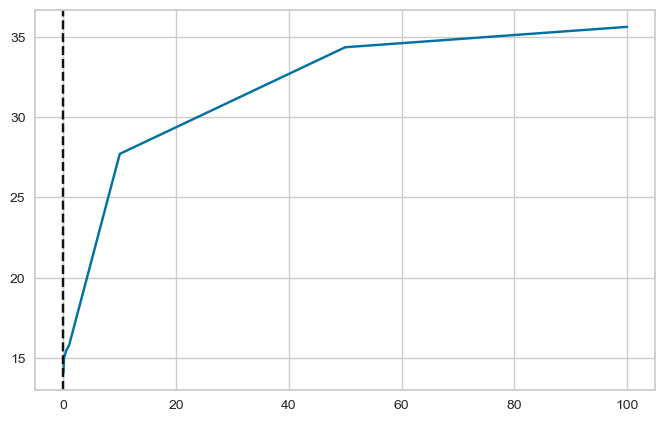

In [76]:
from yellowbrick.regressor import AlphaSelection

plt.figure(figsize=(8, 8 / 1.618));

visualization = AlphaSelection(LassoCV(alphas=lambdas))
visualization.fit(X_train, y_train) 


## Comparing Regressions

We can compare each of the regressions side-by-side: linear, ridge, and lasso.  

We can see lasso has increased the regression $R^2$ value marginally, ie, we have a "better fit" with fewer coefficient magnitudes, but it's a slim improvement.  

Remember $R^2$ higher is generally better. Too high is problematic. 

In any case, the improvement is little-to-none across the various modes. This leads us to a more advanced topic later.

In [ ]:
linear_regression = 0.818749

# Best Lambda: 0.0001 with R-squared: 0.8187486890969113
ridge_regression = 0.8187486890969113

#Best Lambda:  0.000010 R2_score:  0.818795
lasso_regression = 0.818795
